In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.4


In [2]:
# N_Cls = 10
N_Cls = 1
inDir = '/home/ubuntu/data/dstl/data'
topDir = '/home/ubuntu/data/dstl'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 160
smooth = 1e-12

In [3]:
DF = DF.loc[(DF['ClassType'] == 1)] # | (DF['ClassType'] == 2)]
print len(DF)

25


In [4]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


In [5]:
def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


In [6]:
def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


In [7]:
def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

In [8]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

In [9]:
def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

In [10]:

def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img


In [11]:
def stretch_n(bands, lower_percent=5, higher_percent=95):
#     out = np.zeros_like(bands)    
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


In [12]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

In [13]:
def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [14]:
def stick_all_train():
    print "let's stick all imgs together"
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print len(ids)
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print img.shape, id, np.amax(img), np.amin(img)
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print np.amax(y), np.amin(y)

#      np.save('data/x_trn_%d' % N_Cls, x)
#      np.save('data/y_trn_%d' % N_Cls, y)

    np.save(inDir + '/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/y_trn_%d' % N_Cls, y)

In [15]:
def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y)
    return x, y


In [16]:
def make_val():
    print "let's pick some samples for validation"
    img = np.load(inDir + '/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_trn_%d.npy' % N_Cls)
#     img = np.load('data/x_trn_%d.npy' % N_Cls)
#     msk = np.load('data/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)

#     np.save('data/x_tmp_%d' % N_Cls, x)
#     np.save('data/y_tmp_%d' % N_Cls, y)
    
    np.save(inDir + '/x_tmp_%d' % N_Cls, x)
    np.save(inDir + '/y_tmp_%d' % N_Cls, y)
    
    

In [17]:

def get_unet():
    print "build network"
    inputs = Input((8, ISZ, ISZ))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [18]:
def calc_jacc(model):
    img = np.load(inDir + '/x_tmp_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print prd.shape, msk.shape
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print i, m, b_tr
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs


In [19]:
def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


In [20]:

def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons



In [21]:
def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min



In [22]:
def train_net():
    print "start train net"
    x_val, y_val = np.load(inDir + '/x_tmp_%d.npy' % N_Cls), np.load(inDir +'/y_tmp_%d.npy' % N_Cls)
   
    img = np.load(inDir + '/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)
    print np.ndim(x_trn)
    print np.ndim(y_trn)
    model = get_unet()

#
#    model.load_weights(topDir + '/weights/unet_10_jk0.7878')
    model.load_weights(topDir + '/weights/baseline.w')
    model_checkpoint = ModelCheckpoint(topDir + '/weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(N_Cls):
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=10, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print 'val jk', score
        model.save_weights(topDir + '/weights/unet_10_jk%.4f' % score)

    return model

In [23]:
def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]

In [24]:
def predict_test(model, trs):
    print "predict test"
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save(topDir + '/msk/10_%s' % id, msk)
        if i % 100 == 0: print i, id

In [85]:
def make_submit():
    print "make submission file"
    df = pd.read_csv(os.path.join(topDir + '/subm/BASELINE__empty_with_true_train.csv'))
    print df.head()
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1
        if kls == 0: #  class 0 is buildings
            msk = np.load(topDir + '/msk/10_%s.npy' % id)[kls]
            pred_polygons = mask_to_polygons(msk)
            x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
            y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

            x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

            scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,origin=(0, 0, 0))
            df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
    print df.head()
    df.to_csv(topDir + '/subm/buildings3.csv', index=False)

In [84]:
#model.load_weights(topDir + '/weights/buildings.w')
model.load_weights(topDir + '/weights/buildings.w')
    #model_checkpoint = ModelCheckpoint(topDir + '/weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
for i in range(N_Cls):
    model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, verbose=1, shuffle=True, validation_data=(x_val, y_val))
    del x_trn
    del y_trn
    x_trn, y_trn = get_patches(img, msk)
    score, trs = calc_jacc(model)
    print 'val jk', score
    #model.save_weights(topDir + '/weights/unet_10_jk%.4f' % score)

model.save_weights(topDir + '/weights/buildings.w')
make_submit()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 233 samples, validate on 69 samples
Epoch 1/1
233/233 [==============================] - 26s - loss: 0.4526 - jaccard_coef: 0.5107 - jaccard_coef_int: 0.5107 - acc: 0.7915 - val_loss: 0.4498 - val_jaccard_coef: 0.5060 - val_jaccard_coef_int: 0.5060 - val_acc: 0.7891
(244, 8, 160, 160) (244, 1, 160, 160) 1.0 -1.0 1.0 0.0
(69, 1, 160, 160) (69, 1, 160, 160)


Self-intersection at or near point 636.18965517241384 25.137931034482758
Self-intersection at or near point 310.28198433420363 631.02088772845957


0 0.615399405094 0.3
val jk 0.0615399405094
make submission file
    ImageId  ClassType     MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON EMPTY
1  6120_2_4          2  MULTIPOLYGON EMPTY
2  6120_2_4          3  MULTIPOLYGON EMPTY
3  6120_2_4          4  MULTIPOLYGON EMPTY
4  6120_2_4          5  MULTIPOLYGON EMPTY
0


Self-intersection at or near point 839.42307692307691 637.65384615384619
Self-intersection at or near point 786.06299212598424 91.629921259842519
Self-intersection at or near point 790.43956043956041 15.351648351648352
Self-intersection at or near point 598.11302211302211 258.94594594594594
Self-intersection at or near point 795.36434108527135 619.89147286821708
Self-intersection at or near point 793.38509316770183 319.05590062111798
Self-intersection at or near point 799.02531645569616 482.17721518987344
Self-intersection at or near point 549.0526315789474 87.754385964912274
Self-intersection at or near point 644.87128712871288 780.68316831683171
Self-intersection at or near point 727.48936170212767 255.47340425531914
Self-intersection at or near point 839.31578947368416 446.64473684210526


100


Self-intersection at or near point 778.18348623853205 653.54128440366969
Self-intersection at or near point 637.26666666666665 118.01666666666667
Self-intersection at or near point 592.41558441558436 171.61471861471861
Self-intersection at or near point 76.225130890052355 166.91099476439791
Self-intersection at or near point 483.82776349614397 441.92802056555269
Self-intersection at or near point 839.28571428571433 417.42857142857144
Self-intersection at or near point 802.44414168937328 520.68119891008178
Self-intersection at or near point 813.48979591836735 273.57142857142856
Self-intersection at or near point 817.47955390334573 114.25650557620818


200


Self-intersection at or near point 801.77450980392155 408.69117647058823
Self-intersection at or near point 802.02586206896547 582.91379310344826
Self-intersection at or near point 806.67361111111109 166.14583333333334
Self-intersection at or near point 822.18848167539272 793.3403141361257
Self-intersection at or near point 844.47217235188509 404.77019748653498
Self-intersection at or near point 784.81081081081084 690.32432432432438
Self-intersection at or near point 842.51778656126487 235.399209486166
Self-intersection at or near point 834.89473684210532 461.81578947368422
Self-intersection at or near point 814.62616822429902 324.04672897196264
Self-intersection at or near point 832.41509433962267 825.4905660377359
Self-intersection at or near point 134.74603174603175 796.3650793650794


300


Self-intersection at or near point 504.56 288.83999999999997
Self-intersection at or near point 830.19230769230774 328.11538461538464
Self-intersection at or near point 814.07171314741038 123.45019920318725
Self-intersection at or near point 73.173677069199456 799.90230664857529
Self-intersection at or near point 803.89473684210532 808.9473684210526
Self-intersection at or near point 752.2168674698795 358.25301204819277
Self-intersection at or near point 123.84313725490196 239.9607843137255
Self-intersection at or near point 781.12068965517244 453.27586206896552
Self-intersection at or near point 165.15605749486653 595.49281314168377
Self-intersection at or near point 770.58241758241763 169.62637362637363


400


Self-intersection at or near point 807.63793103448279 112.72413793103448
Self-intersection at or near point 802.36482084690556 310.95439739413683
Self-intersection at or near point 799.50793650793651 484.44444444444446
Self-intersection at or near point 794.41176470588232 792.24705882352941
Self-intersection at or near point 844 383.19999999999999
Self-intersection at or near point 215.21782178217822 778.98019801980195
Self-intersection at or near point 798.73749999999995 388.64999999999998
Self-intersection at or near point 696.10489510489515 14.384615384615385
Self-intersection at or near point 598 394.23809523809524
Self-intersection at or near point 838.51999999999998 829.51999999999998


500


Self-intersection at or near point 846.0150753768844 355.391959798995
Self-intersection at or near point 792.93103448275861 382.9655172413793
Self-intersection at or near point 839.21818181818185 18.727272727272727
Self-intersection at or near point 833.50276243093924 370.07734806629833
Self-intersection at or near point 810.67123287671234 472.63013698630135
Self-intersection at or near point 843.81012658227849 808.65822784810132
Self-intersection at or near point 794.97087378640776 752.242718446602
Self-intersection at or near point 838.29411764705878 159.09803921568627


600


Self-intersection at or near point 824.71283783783781 728.63175675675677
Self-intersection at or near point 844.36311239193083 178.2622478386167
Self-intersection at or near point 829.91379310344826 281.75862068965517
Self-intersection at or near point 801.6615384615385 92.338461538461544
Self-intersection at or near point 751.99845916795073 473.22496147919878
Self-intersection at or near point 845.12026359143329 776.73311367380563
Self-intersection at or near point 820.60000000000002 316.80000000000001
Self-intersection at or near point 671.94794520547941 139.53150684931506
Self-intersection at or near point 709.10769230769233 833.67692307692312
Self-intersection at or near point 460.88888888888891 115.88888888888889
Self-intersection at or near point 715.25714285714287 403.52857142857141
Self-intersection at or near point 833.48717948717945 655.61538461538464
Self-intersection at or near point 636.17725752508363 285.78260869565219


700


Self-intersection at or near point 843.84210526315792 437
Self-intersection at or near point 639.04878048780483 526.41463414634143
Self-intersection at or near point 726.5454545454545 508.72727272727275
Self-intersection at or near point 758.78481012658233 79.303797468354432
Self-intersection at or near point 835.7020109689214 154.23948811700183
Self-intersection at or near point 708.44859813084111 326.20560747663552
Self-intersection at or near point 819.22222222222217 132.27777777777777
Self-intersection at or near point 790.85380116959061 713.67251461988303
Self-intersection at or near point 826.84347826086957 476.3478260869565


800


Self-intersection at or near point 844.60773480662988 591.85082872928172
Self-intersection at or near point 733.71428571428567 810
Self-intersection at or near point 796.48571428571427 799.25714285714287
Self-intersection at or near point 849.41666666666663 368
Self-intersection at or near point 636.80918727915196 704.97879858657245
Self-intersection at or near point 825.63414634146341 730.68292682926824
Self-intersection at or near point 808.94573643410854 317.15503875968994
Self-intersection at or near point 572.09463722397481 543.93059936908514
Self-intersection at or near point 843.21951219512198 650.80487804878044


900


Self-intersection at or near point 692.57142857142856 560.89795918367349
Self-intersection at or near point 660.55172413793105 210.10344827586206
Self-intersection at or near point 810.70610687022895 601.1870229007634
Self-intersection at or near point 776.68141592920358 569.44247787610618
Self-intersection at or near point 481.68421052631578 13.315789473684211
Self-intersection at or near point 736.29707112970709 225.28870292887029
Self-intersection at or near point 834.88590604026842 292.46756152125278
Self-intersection at or near point 805.13043478260875 91.869565217391298
Self-intersection at or near point 801.86330935251794 37.942446043165468
Self-intersection at or near point 673.74117647058824 263.81176470588235
Self-intersection at or near point 766.63636363636363 62.090909090909093


1000


Self-intersection at or near point 787.51879699248116 426.25563909774434
Self-intersection at or near point 341.0503144654088 170.06289308176102
Self-intersection at or near point 761.93333333333328 326.25333333333333
Self-intersection at or near point 396.50632911392404 121.41772151898734
Self-intersection at or near point 769.07865168539331 223.47191011235955
Self-intersection at or near point 805.08968609865474 819.28699551569503
Self-intersection at or near point 669.10135135135135 825.08783783783781
Self-intersection at or near point 739.78006872852234 320.46735395189006
Self-intersection at or near point 845.51815980629544 610.56416464891038
Self-intersection at or near point 616.13888888888891 638.02777777777783


1100


Self-intersection at or near point 132.6897810218978 633.19343065693431
Self-intersection at or near point 422.94520547945206 60.80821917808219
Self-intersection at or near point 844.8716577540107 89.721925133689837
Self-intersection at or near point 713.01775147928993 14.414201183431953
Self-intersection at or near point 802.32530120481931 815.07228915662654
Self-intersection at or near point 736.70270270270271 184.27027027027026
Self-intersection at or near point 683.82352941176475 704.17647058823525
Self-intersection at or near point 839.05972696245738 639.25085324232077
Self-intersection at or near point 676.24161073825508 683.78523489932888
Self-intersection at or near point 624.82857142857142 182.21142857142857


1200


Self-intersection at or near point 699.90909090909088 610.63636363636363
Self-intersection at or near point 830.02234636871503 800.31284916201116
Self-intersection at or near point 677.75757575757575 54.31818181818182
Self-intersection at or near point 524.75 747
Self-intersection at or near point 769.44000000000005 340.04000000000002
Self-intersection at or near point 709.25130890052355 476.05759162303667
Self-intersection at or near point 602.05594405594411 273.39860139860139
Self-intersection at or near point 691.40776699029129 522.08737864077671
Self-intersection at or near point 840.497512437811 34.049751243781095


1300


Self-intersection at or near point 844.91182795698921 575.65161290322578
Self-intersection at or near point 685.58064516129036 499.16129032258067
Self-intersection at or near point 770.81818181818187 246.54545454545453
Self-intersection at or near point 750.35426008968614 371.96412556053809
Self-intersection at or near point 808.05600000000004 286.88
Self-intersection at or near point 802.89999999999998 580.5
Self-intersection at or near point 650.47058823529414 440.41176470588238
Self-intersection at or near point 791.46341463414637 210.73170731707316
Self-intersection at or near point 378.82208588957053 324.07975460122697
Self-intersection at or near point 818.4666666666667 1.4666666666666666
Self-intersection at or near point 759.15625 585.90625


1400


Self-intersection at or near point 801.09523809523807 203.14285714285714
Self-intersection at or near point 249.46560846560845 662.4232804232804
Self-intersection at or near point 819.08333333333337 148.91666666666666
Self-intersection at or near point 385.11464968152865 387.20063694267515
Self-intersection at or near point 816.046875 373.609375
Self-intersection at or near point 778.89473684210532 751.73684210526312
Self-intersection at or near point 831.36000000000001 554.48000000000002
Self-intersection at or near point 694.91304347826087 176.21739130434781


1500


Self-intersection at or near point 831.93220338983053 489.16949152542372
Self-intersection at or near point 619.08333333333337 709.83333333333337
Self-intersection at or near point 816.63583815028903 298.7976878612717
Self-intersection at or near point 163.06709265175718 159.21405750798721
Self-intersection at or near point 822.85142857142853 56.171428571428571
Self-intersection at or near point 728.33333333333337 500.5
Self-intersection at or near point 844.57894736842104 832.15789473684208
Self-intersection at or near point 623.36363636363637 833.68686868686871
Self-intersection at or near point 775.84126984126988 623.53968253968253
Self-intersection at or near point 780.22916666666663 319.875
Self-intersection at or near point 845.12 117.92


1600


Self-intersection at or near point 844.70076726342711 658.21994884910487
Self-intersection at or near point 788.53987730061351 811.53374233128829
Self-intersection at or near point 830.43661971830988 219.74647887323943
Self-intersection at or near point 845.58762886597935 239.28865979381445
Self-intersection at or near point 843.36111111111109 430.79166666666669
Self-intersection at or near point 825.8784810126582 224.63797468354431
Self-intersection at or near point 843.25714285714287 43.74285714285714
Self-intersection at or near point 708.06239168110915 169.12824956672443
Self-intersection at or near point 832.49253731343288 776.44776119402979
Self-intersection at or near point 845.87202380952385 317.0654761904762
Self-intersection at or near point 712.05737704918033 389.96311475409834


1700


Self-intersection at or near point 798.59259259259261 160.16666666666666
Self-intersection at or near point 743.83673469387759 222.16326530612244
Self-intersection at or near point 828.92857142857144 810.89285714285711
Self-intersection at or near point 191.94539249146757 682.69965870307169
Self-intersection at or near point 779 758.23076923076928
Self-intersection at or near point 801.04761904761904 470.87301587301585
Self-intersection at or near point 782.07317073170736 748.82926829268297


1800


Self-intersection at or near point 843.85082872928172 722.91712707182319
Self-intersection at or near point 687.4070351758794 452.2713567839196
Self-intersection at or near point 843.33333333333337 344.33333333333331
Self-intersection at or near point 794.38032305433183 567.78707782672541
Self-intersection at or near point 586.32786885245901 446.39344262295083
Self-intersection at or near point 685.28791773778926 499.26735218508998
Self-intersection at or near point 148.52962962962962 245.28888888888889
Self-intersection at or near point 830.07407407407402 313.07407407407408
Self-intersection at or near point 435 117.625
Self-intersection at or near point 845 271
Self-intersection at or near point 642.0344827586207 677.13793103448279


1900


Self-intersection at or near point 583.04651162790697 513.25581395348843
Self-intersection at or near point 781.72033898305085 156.77118644067798
Self-intersection at or near point 835.69230769230774 176.84615384615384
Self-intersection at or near point 803.90675990675993 437.55710955710958
Self-intersection at or near point 734.04697986577185 836.76510067114089
Self-intersection at or near point 830.39393939393938 771.19191919191917
Self-intersection at or near point 382.03814713896458 699.57220708446869
Self-intersection at or near point 832.5275590551181 595.35433070866145


2000


Self-intersection at or near point 692.09090909090912 73.090909090909093
Self-intersection at or near point 798.27249022164278 479.01434159061279
Self-intersection at or near point 833.4375 390.4375
Self-intersection at or near point 548.44444444444446 553
Self-intersection at or near point 820.09433962264154 677.11320754716985
Self-intersection at or near point 789.14414414414409 420.54954954954957
Self-intersection at or near point 812.93953488372097 785.38604651162791
Self-intersection at or near point 819 474.3125
Self-intersection at or near point 801.85263157894735 36.536842105263155
Self-intersection at or near point 805.78010471204186 190.73298429319371


2100


Self-intersection at or near point 665.88235294117646 737.58823529411768
Self-intersection at or near point 790.19083969465646 310.6564885496183
Self-intersection at or near point 708.83516483516485 5.9340659340659343
Self-intersection at or near point 758.08571428571429 691.45714285714291
Self-intersection at or near point 828.29104477611941 389.06716417910445
Self-intersection at or near point 798.58333333333337 48.347222222222221
Self-intersection at or near point 804.78947368421052 807.78947368421052
Self-intersection at or near point 815.22580645161293 720.38709677419354
Self-intersection at or near point 828.77777777777783 501.97222222222223
Self-intersection at or near point 749.625 291.125


2200


Self-intersection at or near point 803.11604095563143 659.32764505119451
Self-intersection at or near point 812.61643835616439 474.05479452054794
Self-intersection at or near point 161 159.25
Self-intersection at or near point 685.77215189873414 214.98734177215189
Self-intersection at or near point 815.83435582822085 453.44171779141107
Self-intersection at or near point 825.18421052631584 794.07894736842104
Self-intersection at or near point 836.21148825065279 605.30548302872057
Self-intersection at or near point 762.98245614035091 740.87719298245611
Self-intersection at or near point 791.91666666666663 429.10416666666669
Self-intersection at or near point 673.62427745664741 673.86127167630059


2300


Self-intersection at or near point 781.02702702702697 184.91891891891891
Self-intersection at or near point 727.29914529914527 662.02136752136755
Self-intersection at or near point 592.9473684210526 101.47368421052632
Self-intersection at or near point 827.17999999999995 244.97999999999999
Self-intersection at or near point 625.875 498.3125
Self-intersection at or near point 847 219.25
Self-intersection at or near point 798.85057471264372 290.68965517241378
Self-intersection at or near point 580.79611650485435 371.13592233009706
Self-intersection at or near point 846.88524590163934 15.049180327868852


2400


Self-intersection at or near point 832.17391304347825 576.08695652173913
Self-intersection at or near point 823.61290322580646 560.45161290322585
Self-intersection at or near point 792.24561403508767 620.12280701754389
Self-intersection at or near point 846.70588235294122 576.35294117647061
Self-intersection at or near point 550.92779783393507 327.15884476534296
Self-intersection at or near point 513.78947368421052 583.42105263157896
Self-intersection at or near point 749.00682593856652 393.92491467576792
Self-intersection at or near point 463.33898305084745 500.0169491525424
Self-intersection at or near point 822.35059760956176 786.41434262948212
Self-intersection at or near point 514.16309012875536 12.866952789699571
Self-intersection at or near point 822.69117647058829 184.16911764705881


2500


Self-intersection at or near point 255.94059405940595 27.415841584158414
Self-intersection at or near point 548.48453608247428 793.93814432989689
Self-intersection at or near point 763.6683417085427 601.3969849246231
Self-intersection at or near point 802.73529411764707 782.32352941176475
Self-intersection at or near point 820.17499999999995 24.274999999999999
Self-intersection at or near point 142.66666666666666 473.33333333333331
Self-intersection at or near point 842.6521739130435 523.6521739130435
Self-intersection at or near point 846.44897959183675 663.42857142857144
Self-intersection at or near point 625.50602409638554 611.67469879518069
Self-intersection at or near point 737.62337662337666 244.46753246753246
Self-intersection at or near point 787.1604278074866 808.04812834224595
Self-intersection at or near point 844.61904761904759 597.76190476190482


2600


Self-intersection at or near point 839.91729323308266 390.89473684210526
Self-intersection at or near point 769.06451612903231 567.82795698924735
Self-intersection at or near point 804.17699115044252 818.86725663716811
Self-intersection at or near point 672.78132118451026 802.67653758542144
Self-intersection at or near point 816.70175438596493 437.82456140350877
Self-intersection at or near point 821.63636363636363 453
Self-intersection at or near point 836.90909090909088 574.78787878787875
Self-intersection at or near point 823.52307692307693 392.96923076923076
Self-intersection at or near point 796.72588832487304 207.21827411167513


2700


Self-intersection at or near point 846.88888888888891 224.91666666666666
Self-intersection at or near point 47.200000000000003 346.80000000000001
Self-intersection at or near point 706.68965517241384 821.89655172413791
Self-intersection at or near point 554.86206896551721 190.06896551724137
Self-intersection at or near point 822.72483221476512 604.33557046979865
Self-intersection at or near point 569.79389312977094 316.32061068702291
Self-intersection at or near point 533.55555555555554 513
Self-intersection at or near point 832.63190184049074 444.60122699386505
Self-intersection at or near point 814.0277264325324 823.07208872458409


2800


Self-intersection at or near point 793.90909090909088 462.09090909090907
Self-intersection at or near point 730.57446808510633 611.63829787234044
Self-intersection at or near point 640.36842105263156 772.84210526315792
Self-intersection at or near point 762.86770428015564 169.01167315175098
Self-intersection at or near point 795.42857142857144 180.85714285714286
Self-intersection at or near point 553.02298850574709 158.12068965517241
Self-intersection at or near point 765.62222222222226 502.13333333333333
Self-intersection at or near point 759.33333333333337 28.666666666666668


2900


Self-intersection at or near point 726.74193548387098 104.51612903225806
Self-intersection at or near point 613.29940119760477 767.83832335329339
Self-intersection at or near point 830.14189189189187 117.0304054054054
Self-intersection at or near point 658.58565737051788 305.80876494023903
Self-intersection at or near point 815.21428571428567 306.14285714285717
Self-intersection at or near point 809.06654991243431 331.88266199649735
Self-intersection at or near point 625.23788546255503 364.74889867841409
Self-intersection at or near point 736.10169491525426 250.78813559322035
Self-intersection at or near point 771.84000000000003 275.16000000000003
Self-intersection at or near point 820.50495049504946 63.415841584158414


3000


Self-intersection at or near point 836.73170731707319 828.92682926829264
Self-intersection at or near point 782.03584229390685 777.36559139784947
Self-intersection at or near point 821.59420289855075 479.74637681159419
Self-intersection at or near point 831.70399999999995 520.37599999999998
Self-intersection at or near point 824.42307692307691 457.5
Self-intersection at or near point 844.84816753926702 203.86387434554973
Self-intersection at or near point 821.26765799256509 579.41635687732344
Self-intersection at or near point 841 156.5
Self-intersection at or near point 826.9473684210526 637.22368421052636


3100


Self-intersection at or near point 806 323
Self-intersection at or near point 814.8910505836576 745.94163424124508
Self-intersection at or near point 833.13186813186815 833.16483516483515
Self-intersection at or near point 624.58823529411768 794.94117647058829
Self-intersection at or near point 741.61403508771934 27.92982456140351
Self-intersection at or near point 705.38461538461536 217.61538461538461
Self-intersection at or near point 799.69473684210527 807.03157894736842
Self-intersection at or near point 48.222222222222221 340.88888888888891
Self-intersection at or near point 475.37209302325579 786.39534883720933
Self-intersection at or near point 833.27272727272725 204.72727272727272


3200


Self-intersection at or near point 828.83044982698959 301.63667820069202
Self-intersection at or near point 833.34210526315792 17.956140350877192
Self-intersection at or near point 396.57142857142856 78
Self-intersection at or near point 495.74345549738217 784.51832460732987
Self-intersection at or near point 734.42105263157896 268.64912280701753
Self-intersection at or near point 411.78040540540542 342.96283783783781
Self-intersection at or near point 797.695652173913 609.304347826087
Self-intersection at or near point 474.8767123287671 372.08219178082192
Self-intersection at or near point 354.25 794.375
Self-intersection at or near point 842.77007874015749 500.43464566929134
Self-intersection at or near point 799.48034934497821 506.86899563318775


3300


Self-intersection at or near point 813.18584070796464 667.99115044247787
Self-intersection at or near point 816.55902777777783 293.93055555555554
Self-intersection at or near point 574.4545454545455 502.72727272727275
Self-intersection at or near point 802.77714285714285 142.31999999999999
Self-intersection at or near point 676.1293532338309 99.228855721393032
Self-intersection at or near point 560.11111111111109 730.55555555555554
Self-intersection at or near point 844.83098591549299 612.27464788732391
Self-intersection at or near point 795.10526315789468 536.42105263157896
Self-intersection at or near point 285.09090909090907 639.81818181818187
Self-intersection at or near point 838.30769230769226 320.30769230769232
Self-intersection at or near point 685.41250000000002 732.07500000000005


3400


Self-intersection at or near point 779.38461538461536 160
Self-intersection at or near point 441.71428571428572 648
Self-intersection at or near point 795.36029411764707 602.70588235294122
Self-intersection at or near point 701.63485477178426 392.32780082987551
Self-intersection at or near point 501.77777777777777 115
Self-intersection at or near point 347.40677966101697 58.355932203389834
Self-intersection at or near point 753.43835616438355 294.65068493150687
Self-intersection at or near point 736.23148148148152 217.18518518518519
Self-intersection at or near point 840.43478260869563 111.30434782608695


3500


Self-intersection at or near point 827.84070796460173 146.52212389380531
Self-intersection at or near point 748.64285714285711 367.64285714285717
Self-intersection at or near point 843.4711111111111 536.84888888888884
Self-intersection at or near point 714.9375 641.4375
Self-intersection at or near point 752 0.6875
Self-intersection at or near point 777.30508474576266 636.28813559322032
Self-intersection at or near point 697.42731277533039 288.82378854625551
Self-intersection at or near point 655.79470198675494 353.42384105960264
Self-intersection at or near point 726.90322580645159 466.82580645161289
Self-intersection at or near point 770.26923076923072 224.88461538461539


3600


Self-intersection at or near point 765.70623145400589 421.459940652819
Self-intersection at or near point 547.7038626609442 491.84978540772534
Self-intersection at or near point 663.33333333333337 386.75
Self-intersection at or near point 839.12307692307695 73.611538461538458
Self-intersection at or near point 799.3478260869565 830.91304347826087
Self-intersection at or near point 690.84210526315792 332.15789473684208
Self-intersection at or near point 711.82352941176475 34.764705882352942
Self-intersection at or near point 846.82926829268297 589.8780487804878


3700


Self-intersection at or near point 821.37037037037032 36.527777777777779
Self-intersection at or near point 843.67924528301887 578.81132075471703
Ring Self-intersection at or near point 388 0
Self-intersection at or near point 812.14173228346453 828.64566929133855
Self-intersection at or near point 793.64788732394368 158.11267605633802
Self-intersection at or near point 50.184873949579831 594.99159663865544
Self-intersection at or near point 214.47058823529412 422.76470588235293
Self-intersection at or near point 199.89570552147239 25.760736196319019
Self-intersection at or near point 844.95348837209303 418.01550387596899
Self-intersection at or near point 836.5 601.75


3800


Self-intersection at or near point 842.4666666666667 172.53333333333333
Self-intersection at or near point 843.88888888888891 159
Self-intersection at or near point 664.80799999999999 651.22400000000005
Self-intersection at or near point 831.60747663551399 70.654205607476641
Self-intersection at or near point 586.05309734513276 328.91150442477874
Self-intersection at or near point 608.15309126594695 0.14131501472031405
Self-intersection at or near point 830.38333333333333 670.45833333333337
Self-intersection at or near point 631.16666666666663 641.5
Self-intersection at or near point 833 659.71428571428567
Self-intersection at or near point 844.73913043478262 667.81366459627327


3900


Self-intersection at or near point 815.62162162162167 689.54054054054052
Self-intersection at or near point 842.89454545454544 678.75636363636363
Self-intersection at or near point 831.03846153846155 278.51923076923077
Self-intersection at or near point 838.79999999999995 711.60000000000002
Self-intersection at or near point 805.25 260.4375
Self-intersection at or near point 839.63636363636363 485.36363636363637
Self-intersection at or near point 838.656050955414 84.71337579617834
Self-intersection at or near point 805.05734767025092 515.93548387096769
Self-intersection at or near point 727.30769230769226 165.07692307692307
Self-intersection at or near point 836.23255813953483 313.13953488372096


4000


Self-intersection at or near point 795.82511210762334 589.12107623318389
Self-intersection at or near point 713.66666666666663 811
Self-intersection at or near point 662.27272727272725 737.09090909090912
Self-intersection at or near point 754.60000000000002 587.79999999999995
Self-intersection at or near point 845.66197183098586 747.80281690140851
Self-intersection at or near point 526.30201342281885 236.10738255033556
Self-intersection at or near point 83.5 122
Self-intersection at or near point 827.70588235294122 766.29411764705878
Self-intersection at or near point 845.82926829268297 194.58536585365854
Self-intersection at or near point 276.01063829787233 32.154255319148938
Self-intersection at or near point 719 103.73913043478261
Self-intersection at or near point 788.85714285714289 26.904761904761905


4100


Self-intersection at or near point 845.82648401826486 119.58447488584474
Self-intersection at or near point 602.2197802197802 622.73626373626371
Self-intersection at or near point 825.16666666666663 147.97222222222223
Self-intersection at or near point 839.52941176470586 605.54901960784309
Self-intersection at or near point 702 144.71428571428572
Self-intersection at or near point 706.80701754385962 510.06265664160401
Self-intersection at or near point 840.85517241379307 605.06206896551726
Self-intersection at or near point 834.72727272727275 573.4545454545455


4200


Self-intersection at or near point 810.04907975460128 524.86503067484659
Self-intersection at or near point 4.6036960985626285 827.2156057494866
Self-intersection at or near point 805 105
Self-intersection at or near point 512.5 520.08333333333337
Self-intersection at or near point 794.90909090909088 635.72727272727275
Self-intersection at or near point 793.10638297872345 353.68085106382978
Self-intersection at or near point 801.31884057971013 235.91304347826087


    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0090933836107331 -0.00679080...
1  6120_2_4          2                                 MULTIPOLYGON EMPTY
2  6120_2_4          3                                 MULTIPOLYGON EMPTY
3  6120_2_4          4                                 MULTIPOLYGON EMPTY
4  6120_2_4          5                                 MULTIPOLYGON EMPTY


In [68]:
model.save_weights(topDir + '/weights/buildings.w')

In [26]:
def check_predict(id='6120_2_3'):
    model = get_unet()
#    model.load_weights(topDir + '/weights/unet_10_jk0.7878')
#    model.load_weights(topDir + '/weights/structures.w')
    msk = predict_id(id, model, [0.4, 0.1])#, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure(figsize=(15,10))
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()



In [82]:
def check_predict1(id='6100_1_3'):
    model = get_unet()
#    model.load_weights(topDir + '/weights/unet_10_jk0.7878')
    model.load_weights(topDir + '/weights/buildings.w')
    msk = predict_id(id, model, [0.4]) #, 0.1])#, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure(figsize=(15,10))
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

In [28]:
stick_all_train()

let's stick all imgs together
25
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6010_4_4 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
1.0 0.0


In [29]:
make_val()

let's pick some samples for validation
(69, 8, 160, 160) (69, 1, 160, 160) 1.0 -1.0 1.0 0.0


In [75]:
# Build and display network
#
model = get_unet()
model.summary()

build network


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 8, 160, 160)   0                                            
____________________________________________________________________________________________________
conv2d_58 (Conv2D)               (None, 32, 160, 160)  2336        input_4[0][0]                    
____________________________________________________________________________________________________
conv2d_59 (Conv2D)               (None, 32, 160, 160)  9248        conv2d_58[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D)  (None, 32, 80, 80)    0           conv2d_59[0][0]                  
___________________________________________________________________________________________

In [31]:
x_val, y_val = np.load(inDir + '/x_tmp_%d.npy' % N_Cls), np.load(inDir + '/y_tmp_%d.npy' % N_Cls)
img = np.load(inDir + '/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/y_trn_%d.npy' % N_Cls)


In [32]:
x_trn, y_trn = get_patches(img, msk)

(247, 8, 160, 160) (247, 1, 160, 160) 1.0 -1.0 1.0 0.0


In [33]:
x_val.shape, y_val.shape

((69, 8, 160, 160), (69, 1, 160, 160))

In [40]:
model.fit(x_trn, y_trn, batch_size=64, epochs=200, verbose=1, shuffle=True, validation_data=(x_val, y_val))

Train on 247 samples, validate on 69 samples
Epoch 1/200
247/247 [==============================] - 21s - loss: 0.1079 - jaccard_coef: 0.8613 - jaccard_coef_int: 0.8613 - acc: 0.9535 - val_loss: 0.5442 - val_jaccard_coef: 0.6964 - val_jaccard_coef_int: 0.6964 - val_acc: 0.8527
Epoch 2/200
247/247 [==============================] - 21s - loss: 0.1059 - jaccard_coef: 0.8629 - jaccard_coef_int: 0.8629 - acc: 0.9544 - val_loss: 0.5563 - val_jaccard_coef: 0.7016 - val_jaccard_coef_int: 0.7016 - val_acc: 0.8531
Epoch 3/200
247/247 [==============================] - 21s - loss: 0.1061 - jaccard_coef: 0.8640 - jaccard_coef_int: 0.8640 - acc: 0.9543 - val_loss: 0.5468 - val_jaccard_coef: 0.7010 - val_jaccard_coef_int: 0.7010 - val_acc: 0.8517
Epoch 4/200
247/247 [==============================] - 21s - loss: 0.1212 - jaccard_coef: 0.8523 - jaccard_coef_int: 0.8523 - acc: 0.9474 - val_loss: 0.5152 - val_jaccard_coef: 0.6956 - val_jaccard_coef_int: 0.6956 - val_acc: 0.8525
Epoch 5/200
247/247 [==

247/247 [==============================] - 21s - loss: 0.0997 - jaccard_coef: 0.8713 - jaccard_coef_int: 0.8713 - acc: 0.9572 - val_loss: 0.5820 - val_jaccard_coef: 0.6966 - val_jaccard_coef_int: 0.6966 - val_acc: 0.8519
Epoch 36/200
247/247 [==============================] - 21s - loss: 0.1005 - jaccard_coef: 0.8700 - jaccard_coef_int: 0.8700 - acc: 0.9567 - val_loss: 0.6036 - val_jaccard_coef: 0.7003 - val_jaccard_coef_int: 0.7003 - val_acc: 0.8534
Epoch 37/200
247/247 [==============================] - 21s - loss: 0.1057 - jaccard_coef: 0.8673 - jaccard_coef_int: 0.8673 - acc: 0.9543 - val_loss: 0.6069 - val_jaccard_coef: 0.6879 - val_jaccard_coef_int: 0.6879 - val_acc: 0.8512
Epoch 38/200
247/247 [==============================] - 21s - loss: 0.1122 - jaccard_coef: 0.8596 - jaccard_coef_int: 0.8596 - acc: 0.9513 - val_loss: 0.5745 - val_jaccard_coef: 0.7026 - val_jaccard_coef_int: 0.7026 - val_acc: 0.8523
Epoch 39/200
247/247 [==============================] - 21s - loss: 0.1122 - 

247/247 [==============================] - 21s - loss: 0.1057 - jaccard_coef: 0.8646 - jaccard_coef_int: 0.8646 - acc: 0.9543 - val_loss: 0.5919 - val_jaccard_coef: 0.7037 - val_jaccard_coef_int: 0.7037 - val_acc: 0.8515
Epoch 71/200
247/247 [==============================] - 21s - loss: 0.1073 - jaccard_coef: 0.8645 - jaccard_coef_int: 0.8645 - acc: 0.9536 - val_loss: 0.5694 - val_jaccard_coef: 0.6995 - val_jaccard_coef_int: 0.6995 - val_acc: 0.8526
Epoch 72/200
247/247 [==============================] - 21s - loss: 0.1013 - jaccard_coef: 0.8692 - jaccard_coef_int: 0.8692 - acc: 0.9563 - val_loss: 0.5714 - val_jaccard_coef: 0.6966 - val_jaccard_coef_int: 0.6966 - val_acc: 0.8520
Epoch 73/200
247/247 [==============================] - 21s - loss: 0.0991 - jaccard_coef: 0.8711 - jaccard_coef_int: 0.8711 - acc: 0.9574 - val_loss: 0.5927 - val_jaccard_coef: 0.6979 - val_jaccard_coef_int: 0.6979 - val_acc: 0.8510
Epoch 74/200
247/247 [==============================] - 21s - loss: 0.0959 - 

247/247 [==============================] - 21s - loss: 0.1000 - jaccard_coef: 0.8772 - jaccard_coef_int: 0.8772 - acc: 0.9569 - val_loss: 0.6396 - val_jaccard_coef: 0.7029 - val_jaccard_coef_int: 0.7029 - val_acc: 0.8512
Epoch 106/200
247/247 [==============================] - 21s - loss: 0.0966 - jaccard_coef: 0.8789 - jaccard_coef_int: 0.8789 - acc: 0.9585 - val_loss: 0.6104 - val_jaccard_coef: 0.6966 - val_jaccard_coef_int: 0.6966 - val_acc: 0.8495
Epoch 107/200
247/247 [==============================] - 21s - loss: 0.1018 - jaccard_coef: 0.8727 - jaccard_coef_int: 0.8727 - acc: 0.9561 - val_loss: 0.6058 - val_jaccard_coef: 0.6982 - val_jaccard_coef_int: 0.6982 - val_acc: 0.8513
Epoch 108/200
247/247 [==============================] - 21s - loss: 0.1005 - jaccard_coef: 0.8725 - jaccard_coef_int: 0.8725 - acc: 0.9568 - val_loss: 0.6176 - val_jaccard_coef: 0.7016 - val_jaccard_coef_int: 0.7016 - val_acc: 0.8524
Epoch 109/200
247/247 [==============================] - 21s - loss: 0.095

247/247 [==============================] - 21s - loss: 0.0905 - jaccard_coef: 0.8875 - jaccard_coef_int: 0.8875 - acc: 0.9610 - val_loss: 0.6849 - val_jaccard_coef: 0.6928 - val_jaccard_coef_int: 0.6928 - val_acc: 0.8491
Epoch 140/200
247/247 [==============================] - 21s - loss: 0.0884 - jaccard_coef: 0.8874 - jaccard_coef_int: 0.8874 - acc: 0.9621 - val_loss: 0.6602 - val_jaccard_coef: 0.7045 - val_jaccard_coef_int: 0.7045 - val_acc: 0.8503
Epoch 141/200
247/247 [==============================] - 21s - loss: 0.0879 - jaccard_coef: 0.8872 - jaccard_coef_int: 0.8872 - acc: 0.9624 - val_loss: 0.6624 - val_jaccard_coef: 0.6959 - val_jaccard_coef_int: 0.6959 - val_acc: 0.8502
Epoch 142/200
247/247 [==============================] - 21s - loss: 0.0870 - jaccard_coef: 0.8868 - jaccard_coef_int: 0.8868 - acc: 0.9629 - val_loss: 0.6660 - val_jaccard_coef: 0.7021 - val_jaccard_coef_int: 0.7021 - val_acc: 0.8498
Epoch 143/200
247/247 [==============================] - 21s - loss: 0.085

247/247 [==============================] - 21s - loss: 0.0734 - jaccard_coef: 0.9025 - jaccard_coef_int: 0.9025 - acc: 0.9693 - val_loss: 0.7433 - val_jaccard_coef: 0.6995 - val_jaccard_coef_int: 0.6995 - val_acc: 0.8491
Epoch 174/200
247/247 [==============================] - 21s - loss: 0.0743 - jaccard_coef: 0.9021 - jaccard_coef_int: 0.9021 - acc: 0.9688 - val_loss: 0.7604 - val_jaccard_coef: 0.6987 - val_jaccard_coef_int: 0.6987 - val_acc: 0.8491
Epoch 175/200
247/247 [==============================] - 21s - loss: 0.0883 - jaccard_coef: 0.8923 - jaccard_coef_int: 0.8923 - acc: 0.9623 - val_loss: 0.7343 - val_jaccard_coef: 0.6932 - val_jaccard_coef_int: 0.6932 - val_acc: 0.8502
Epoch 176/200
247/247 [==============================] - 21s - loss: 0.0930 - jaccard_coef: 0.8859 - jaccard_coef_int: 0.8859 - acc: 0.9600 - val_loss: 0.6804 - val_jaccard_coef: 0.6993 - val_jaccard_coef_int: 0.6993 - val_acc: 0.8463
Epoch 177/200
247/247 [==============================] - 21s - loss: 0.090

In [41]:
model.save_weights(topDir + '/weights/buildings.w')
#model.load_weights(topDir + '/weights/buildings.w')

In [87]:
model.fit(x_trn, y_trn, batch_size=64, epochs=50, verbose=1, shuffle=True, validation_data=(x_val, y_val))

Train on 200 samples, validate on 66 samples
Epoch 1/50
200/200 [==============================] - 17s - loss: 0.2532 - jaccard_coef: 0.7038 - jaccard_coef_int: 0.7038 - acc: 0.8874 - val_loss: 0.3071 - val_jaccard_coef: 0.6735 - val_jaccard_coef_int: 0.6735 - val_acc: 0.8648
Epoch 2/50
200/200 [==============================] - 16s - loss: 0.2533 - jaccard_coef: 0.7035 - jaccard_coef_int: 0.7035 - acc: 0.8875 - val_loss: 0.3220 - val_jaccard_coef: 0.6597 - val_jaccard_coef_int: 0.6597 - val_acc: 0.8634
Epoch 3/50
200/200 [==============================] - 16s - loss: 0.2610 - jaccard_coef: 0.6970 - jaccard_coef_int: 0.6970 - acc: 0.8837 - val_loss: 0.3099 - val_jaccard_coef: 0.6686 - val_jaccard_coef_int: 0.6686 - val_acc: 0.8645
Epoch 4/50
200/200 [==============================] - 16s - loss: 0.2515 - jaccard_coef: 0.7024 - jaccard_coef_int: 0.7024 - acc: 0.8884 - val_loss: 0.3103 - val_jaccard_coef: 0.6721 - val_jaccard_coef_int: 0.6721 - val_acc: 0.8663
Epoch 5/50
200/200 [=======

200/200 [==============================] - 17s - loss: 0.2171 - jaccard_coef: 0.7409 - jaccard_coef_int: 0.7409 - acc: 0.9039 - val_loss: 0.3186 - val_jaccard_coef: 0.6969 - val_jaccard_coef_int: 0.6969 - val_acc: 0.8691
Epoch 37/50
200/200 [==============================] - 16s - loss: 0.2150 - jaccard_coef: 0.7433 - jaccard_coef_int: 0.7433 - acc: 0.9049 - val_loss: 0.3315 - val_jaccard_coef: 0.6926 - val_jaccard_coef_int: 0.6926 - val_acc: 0.8691
Epoch 38/50
200/200 [==============================] - 16s - loss: 0.2155 - jaccard_coef: 0.7420 - jaccard_coef_int: 0.7420 - acc: 0.9047 - val_loss: 0.3255 - val_jaccard_coef: 0.6944 - val_jaccard_coef_int: 0.6944 - val_acc: 0.8671
Epoch 39/50
200/200 [==============================] - 16s - loss: 0.2143 - jaccard_coef: 0.7437 - jaccard_coef_int: 0.7437 - acc: 0.9051 - val_loss: 0.3145 - val_jaccard_coef: 0.6901 - val_jaccard_coef_int: 0.6901 - val_acc: 0.8687
Epoch 40/50
200/200 [==============================] - 16s - loss: 0.2120 - jacc

In [42]:
score, trs = calc_jacc(model)

(69, 1, 160, 160) (69, 1, 160, 160)
0 0.70856817934 0.3


In [43]:
predict_test(model, trs)

predict test
0 6010_0_0
100 6050_1_0
200 6090_1_1
300 6130_2_4
400 6170_4_0


build network


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

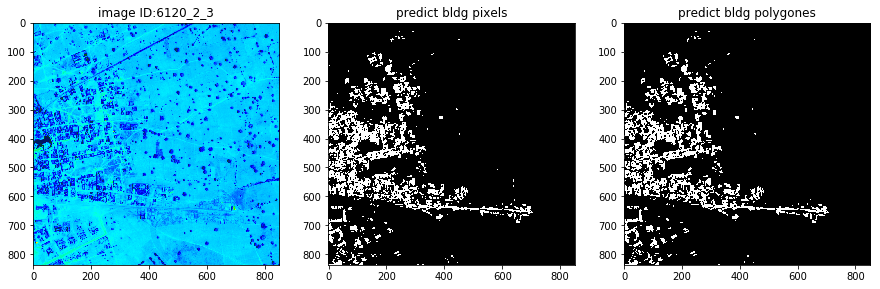

In [81]:
#
#
check_predict()

build network


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

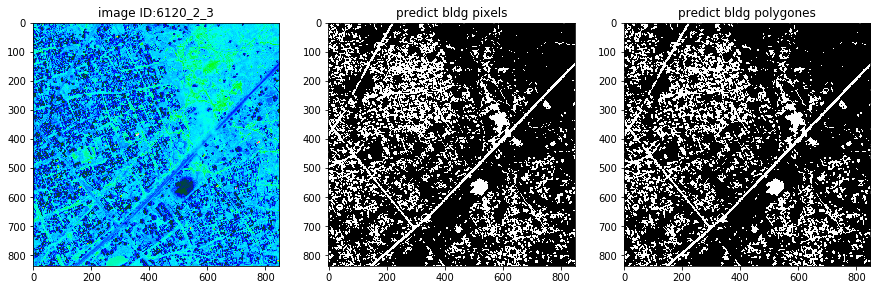

In [83]:
#
#
check_predict1()

In [47]:
# make submission
#
make_submit()

make submission file


IOError: File /home/ubuntu/data/dstl/data/1.csv does not exist

build network


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

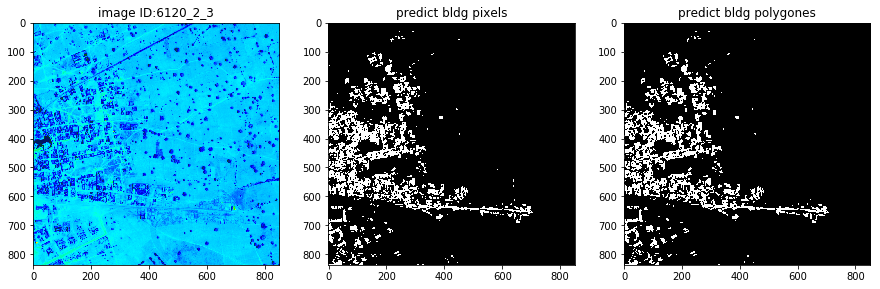

In [78]:
# Check Predicitons
#
check_predict()